In [28]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = 16,8
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Synthetic Data:
Let's start with a simple single-parameter linear regression example:
$$ y=\beta x + \varepsilon$$

We'll set a $\beta$, generate some synthetic data, and then try to compute both a Least-squares estimate $\hat\beta$ and a full a posterior distribution $p(\beta|y)$ under a flat prior.  Note that to generate synthetic data, we also need to choose a value for the variance of $\varepsilon$. $$\varepsilon \sim \mathcal{N}\left(0,\sigma\right)$$ 

(-2.5, 2.5)

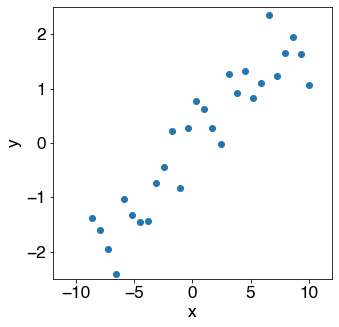

In [29]:
# True parameters:
beta =0.2
sigma_eps  =0.5

# generate synthetic data:
x=np.linspace(-10,10,30)
eps  = stats.norm.rvs(loc=0,scale=sigma_eps,size=len(x)) 

y=beta*x+eps

plt.figure(figsize=(5,5))
plt.plot(x,y,'o')

plt.xlabel('x');
plt.ylabel('y');
plt.xlim(-12,12)
plt.ylim(-2.5,2.5)


### Least Squares Linear regression  Estimate

Text(0, 0.5, 'y')

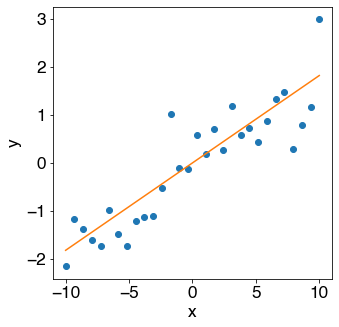

In [3]:
#least squares linear regression:
beta_hat=np.sum(x*y)/np.sum(x**2)
yhat=beta_hat*x

plt.figure(figsize=(5,5))
plt.plot(x,y,'o')
plt.plot(x,yhat)

plt.xlabel('x')
plt.ylabel('y')
#plt.grid()

## Bayesian regression:
#### Model:
The full model can be specified as:

Parameters:
$$\theta =[\beta,\sigma]$$
Likelihood:
$$ y|\theta \sim \mathcal N \left(\beta x , \sigma) \right)$$
Prior: $$ \beta \sim 1$$
$$ \sigma \sim 1$$

#### Computing the posterior:
From Bayes' theorem:
$$p(\theta |y )\sim p(y|\theta)p(\theta)$$

Conditioned on: $$\int p(\theta |y )d\theta =1$$

What this means is we can evaluate the value of $p(\theta |y)$ at any value of $\theta$ we desire. So what we can do is define a grid of $\theta$s at which to evaluate the posterior. 

The full function will be:

$$p(\theta |y )\sim p(y|\theta)p(\theta)=p(y|\theta)=p(y_1,\ldots,y_n|\theta)$$
$$p(\theta |y )\sim \prod_{i=1}^{n}\left(2\pi\sigma^{2}\right)^{-1/2}\exp\left[-\frac{1}{2}\frac{\left(y_{i}-\beta x_{i}\right)^{2}}{\sigma^{2}}\right]$$

$$p\left(\theta|y\right) \sim \left(2\pi\sigma^{2}\right)^{-n/2}\exp\left[-\frac{1}{2\sigma^{2}}\sum_{i=1}^{n}\left(y_{i}-\beta x_{i}\right)^{2}\right]$$

We usually write this in terms of the log-likelihood:
$$\log p\left(\theta|y\right)\sim \frac{n}{2}\log\left(2\pi\sigma^{2}\right)-\frac{1}{2\sigma^{2}}\sum_{i=1}^{n}\left(y_{i}-\beta x_{i}\right)^{2}$$

There's a computational trick here. From this point, we should be able to just exponentiate the expression above, and normalize to have sum=1. In practice, however, the values on the RHS an be very small relative to machine precision, so exponetiating them will yield ~0. Thus, we often times first do a quick normalization to bring them closer to one. This can be done, for example, by removing the maximum of the raw $\log p\left(\theta|y\right)$ over the grid, thus bringing all values of the log-likelihood closer to zero, and the exponentiated values closer to one. 

Let's look at a concrete example

In [4]:
# define a log posterior function
def logpost(y,theta):
    N=len(y)
    beta=theta[0];
    sigma=theta[1];
    yhat=beta*x
    logpost=-N/2*np.log(2*np.pi*sigma**2)-np.sum(1/2*((y-yhat)/sigma)**2)    
    return logpost


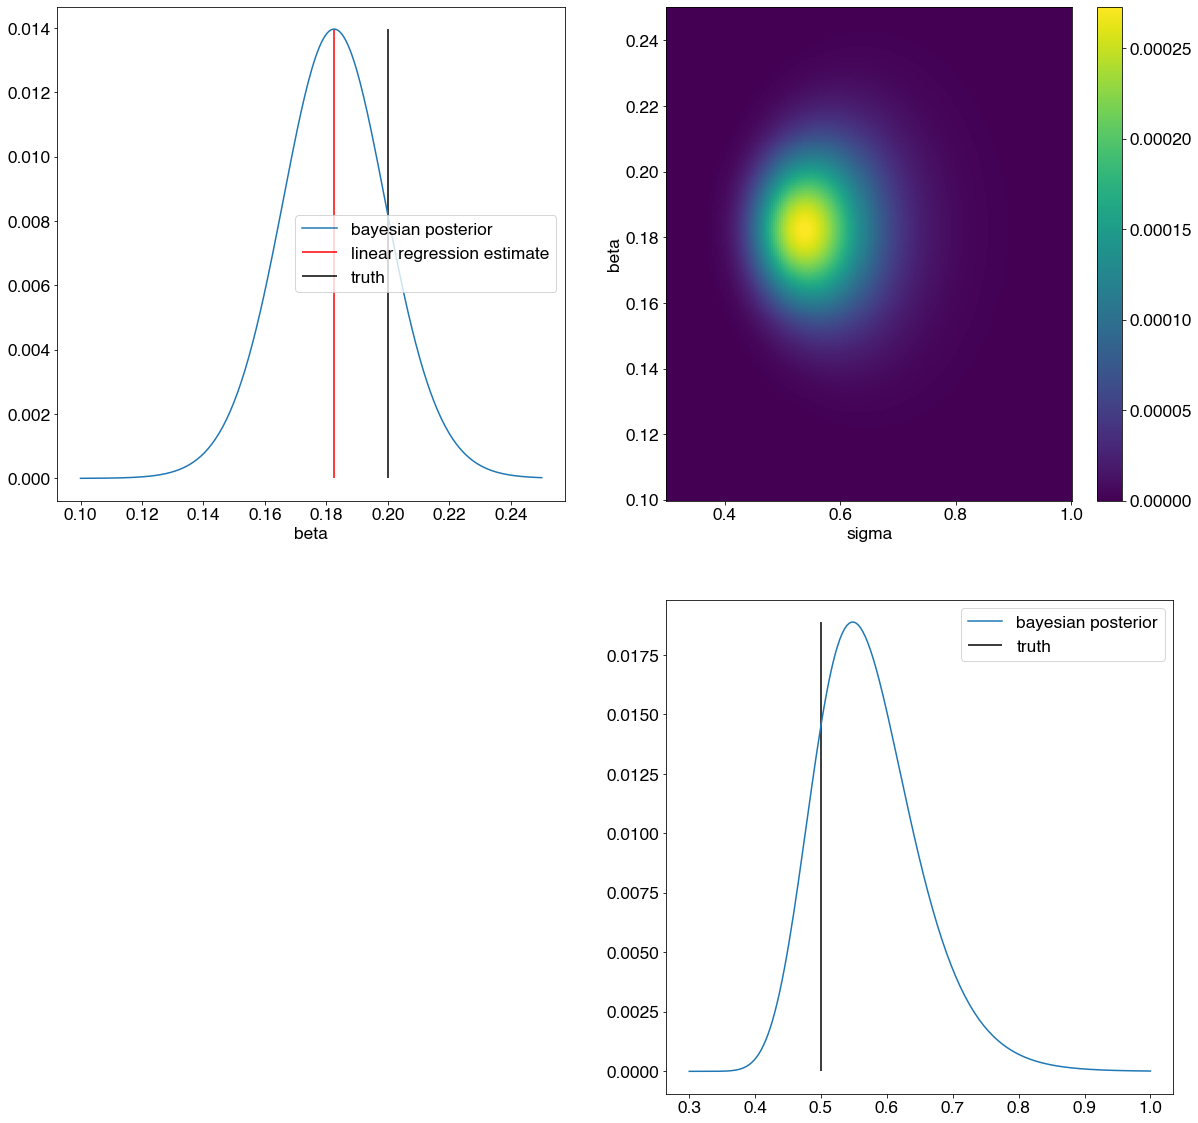

In [27]:

# define a grid over which to evaluate the values of theta (specifically beta and sigma)
beta_vec=np.linspace(0.1,0.25,250)
sig_vec =np.linspace(0.3,1,200)


#initialize the posterior
logpost_grid=np.zeros([len(beta_vec),len(sig_vec)])

#evaluate the posterior at every value on the defined grid
for i in range(len(beta_vec)):
    for j in range(len(sig_vec)):
               theta=[beta_vec[i],sig_vec[j]]
               logpost_grid[i,j]=logpost(y,theta) 

# normalize the posterior. Add the max first for computational accuracy when exponetiating                
logpost_grid=logpost_grid-np.max(logpost_grid)
post=np.exp(logpost_grid)
post=post/np.sum(post)

#Shape of the Posterior distribution p(\theta|y)
np.shape(post)

#compute marginals
post_sig =np.sum(post,0)
post_beta=np.sum(post,1)



#Plots
plt.figure(figsize=[20,20])

plt.subplot(2,2,2)
plt.pcolor(sig_vec,beta_vec,post,shading='auto')
plt.colorbar()
plt.xlabel('sigma')
plt.ylabel('beta')


plt.subplot(2,2,1)
plt.plot(beta_vec,post_beta,label='bayesian posterior')
plt.vlines(beta_hat,np.min(post_beta),np.max(post_beta),'r',label='linear regression estimate')
plt.vlines(beta,np.min(post_beta),np.max(post_beta),'k',label='truth')
plt.xlabel('beta')
plt.legend()

plt.subplot(2,2,4)
plt.plot(sig_vec,post_sig,label='bayesian posterior')
plt.vlines(sigma_eps,np.min(post_sig),np.max(post_sig),'k',label='truth')
plt.legend()

### Exercise 1 (short):
Notice that one issue is that you need some prior guess of where the mass of the posterior is, otherwise a lot of computations are wasted over empty space. 

If it's cheap enough, you can refine the grid to better cover the posterior. 

Play around with the grid:

Rerun the experiment with some of the following grids and notice what happens:
- beta_vec=[-2,2], sig_vec=[0.1,20] (you might start with a broad grid if oyu don't know what to expect)
- beta_vec=[0,1], sig_vec=[0.1 1] (narrowing the grid)
- beta_vec=[0.1,0.3], sig_vec=[0.3,1]
- beta_vec=[0,1], sig_vec=[1,3] (the grid might also not contain the MAP)

### Exercise 2 (long):

Repeat the first exercise, but now add one more parameter, an intercept $y_0$. 

The full model can be specified as:

Parameters:
$$\theta =[\beta,y_0, \sigma]$$
Likelihood:
$$ y|\theta \sim \mathcal N \left(\beta x +y_0, \sigma) \right)$$
Prior: $$ \beta \sim 1$$
$$ \sigma \sim 1$$
$$ y_0 \sim 1$$

Plot the three marginal posteriors $p(\beta|y),p(\y_0|y),p(\sigma|y)$ and the three double joint posteriors: $p(\beta,y_0|y),p(y_0,\sigma|y),p(\sigma,\beta|y)$. Also plot least squares regression estimates for $\beta$ and $y_0$. 


### Exercise 3:
Repeat the base $\theta=[\beta,\sigma]$ case by samplign the posterior using a Metropolis-Hastings algorithm. 

